In [1]:
import nibabel as nib 
#! pip install nibabel --user
import os
import glob
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
#import cv2
#! pip install cv2 --user
import time
from datetime import datetime
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import pandas as pd
import os
from skimage.io import imread
from skimage.color import gray2rgb
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision as tv
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import matplotlib.pyplot as plt
from torch.utils import data as DT
from skimage.transform import radon , iradon
%matplotlib inline
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from sklearn.metrics import r2_score , mean_squared_error

In [2]:
###pad function to resize all images to specific size (here: 64*64*64)

def pad(img_,size_):
    dif=size_-img_.shape[0]
    if dif%2==0:
        img_=np.pad(img_,((dif//2,dif//2),(0,0),(0,0)),'edge')
    else:
        img_=np.pad(img_,(((dif-1)//2,(dif+1)//2),(0,0),(0,0)),'edge')
    dif=size_-img_.shape[1]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(dif//2,dif//2),(0,0)),'edge')
    else:
        img_=np.pad(img_,((0,0),((dif-1)//2,(dif+1)//2),(0,0)),'edge')
    dif=size_-img_.shape[2]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(0,0),(dif//2,dif//2)),'edge')
    else:
        img_=np.pad(img_,((0,0),(0,0),((dif-1)//2,(dif+1)//2)),'edge')
    return img_

In [3]:
# method to save the model
def save_checkpoint(state, filename="my_checkpoint_V3.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

#method to load the saved checkpoint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [38]:
#load all PET and segmentation images(these images are already resampled and have the size of [almost] 64*64*64)
#and add padding if needed

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'

files = [f for f in glob.glob(path + "**/*_ct_gtvt.nii.gz", recursive=True)]
labels_lenght=list()
image_list=list()
label_list=list()
CT_list=list()

for idx,f in enumerate(files):
    SEG_img = nib.load(f)
    SEG_data = SEG_img.get_fdata()
    if SEG_data.shape!=(64,64,64):
        SEG_data=pad(SEG_data,64)
    label_list.append(SEG_data)
    path=f[:-15]+'_pt.nii.gz'
    im=nib.load(path)
    PET_data=im.get_fdata()
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    image_list.append(PET_data)
    path=f[:-15]+'_ct.nii.gz'
    im=nib.load(path)
    CT_data=im.get_fdata()
    if CT_data.shape!=(64,64,64):
        CT_data=pad(CT_data,64)
    CT_list.append(CT_data)
    #print(idx)


In [39]:
len(image_list) # number of patients

200

In [40]:
print (image_list[0].shape) # shape of each image

(64, 64, 64)


In [41]:
print (CT_list[0].shape) # shape of each CT image

(64, 64, 64)


In [46]:
#make label patch of 16*16*16

size = 16 # patch size
stride = 16 # patch stride

all_labels_1=list()
all_labels_2=list()
all_labels_num=list()
all_seg_img=list()

for seg_img in label_list:
    #positive_cells_number=np.sum(seg_img)
    #print("positive_cells_number",positive_cells_number)
    patches = torch.from_numpy(seg_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size)
    #labels_1=(torch.sum(reshaped_patches , dim=(1,2)).int().numpy())/positive_cells_number
    labels_2=(torch.sum(reshaped_patches , dim=(1,2)).int().numpy())/(size*size)

    #print ("labels_", labels_)
    #print ("labels_2", labels_2)
    all_seg_img.append(reshaped_patches)
    #all_labels_1.append(labels_1)
    all_labels_2.append(labels_2)
    all_labels_num.append((torch.sum(reshaped_patches , dim=(1,2)).int().numpy()))
all_labels_num=np.asarray(all_labels_num).reshape(-1)
#all_labels_1=np.asarray(all_labels_1).reshape(-1)
all_labels_2=np.asarray(all_labels_2).reshape(-1)
#all_seg_img=np.asarray(all_seg_img).reshape(-1)

In [47]:
(all_seg_img[199].shape)

torch.Size([1024, 16, 16])

In [49]:
print (all_labels_num[550:750])
#print (all_labels_1[:1024])
print (all_labels_2[550:750])

[162   3   0   0   1   0   0   0   0   0   0   0   0   0   0  33 179   8
   0   0  16   0   0   0   0   0   0   0   0   0   0  40 184  19   0   8
  36   0   0   0   0   0   0   0   2   0   0  45 204  23   0  13  44   1
   0   0   0   0   0   0   2   0   0  47 211  23   0  17  46   1   0   0
   0   0   0   0   2   0   0  50 217  21   0  16  54   1   0   0   0   0
   0   0   0   0   0  48 216  19   0  11  54   1   0   0   0   0   0   0
   0   0   0  45 222  12   0   5  48   0   0   0   0   0   0   0   0   0
   0  41 224   9   0   5  46   0   0   0   0   0   0   0   0   0   0  33
 225   8   0   0  41   0   0   0   0   0   0   0   0   0   0  30 220   7
   0   0  32   0   0   0   0   0   0   0   0   0   0   8 202   0   0   0
  17   0   0   0   0   0   0   0   0   0   0   0 187   0   0   0  12   0
   0   0]
[0.6328125  0.01171875 0.         0.         0.00390625 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.12890625 0.69921875 0.03125
 0.  

In [50]:
#eps=1e-4
eps=0
all_labels=all_labels_2+eps

In [51]:
#make PET_image patch of 16*16*16

all_PET_patches=list()
for PET_img in image_list:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_PET_patches.append(reshaped_patches)
all_PET_patches=np.asarray(all_PET_patches).reshape(-1,size,size)

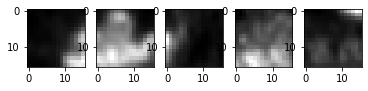

In [52]:
fig = plt.figure()
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(all_PET_patches[549],cmap='gray')
a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(all_PET_patches[550],cmap='gray')
a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(all_PET_patches[551],cmap='gray')
a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(all_PET_patches[552],cmap='gray')
a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(all_PET_patches[553],cmap='gray')

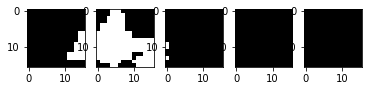

In [56]:
fig = plt.figure()
a = fig.add_subplot(1, 5, 1)
imgplot = plt.imshow(all_seg_img[0][549],cmap='gray')
a = fig.add_subplot(1, 5, 2)
imgplot = plt.imshow(all_seg_img[0][550],cmap='gray')
a = fig.add_subplot(1, 5, 3)
imgplot = plt.imshow(all_seg_img[0][551],cmap='gray')
a = fig.add_subplot(1, 5, 4)
imgplot = plt.imshow(all_seg_img[0][552],cmap='gray')
a = fig.add_subplot(1, 5, 5)
imgplot = plt.imshow(all_seg_img[0][553],cmap='gray')

In [58]:
#make CT_image patch of 16*16*16

all_CT_patches=list()
for CT_img in CT_list:
    patches = torch.from_numpy(CT_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_CT_patches.append(reshaped_patches)
all_CT_patches=np.asarray(all_CT_patches).reshape(-1,size,size)

In [59]:
class HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=all_PET_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [60]:
len (all_labels)

204800

In [61]:
split_threshold=170000  # to split test and train set (11000 out of 1800 for train set)


#print (all_PET_patches.shape) #number of patches * pactch dim1 * patch dim2 * patch dim3

PET_patch_mean=np.mean(all_PET_patches[:split_threshold] , axis=(0,1,2))
PET_patch_std=np.std(all_PET_patches[:split_threshold] , axis=(0,1,2))


# Load Data

idx = list(range(len(all_labels)))

dataset = HN_Dataset( transform=tv.transforms.ToTensor())
train_set = DT.Subset(dataset, idx[:split_threshold])
test_set = DT.Subset(dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 1800])

train_set.transform= tv.transforms.Compose([tv.transforms.RandomHorizontalFlip(),
                                            tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor(),
                                            tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                           ])

test_set.transform= tv.transforms.Compose([#tv.transforms.RandomHorizontalFlip(),
                                            #tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor(),
                                            tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                           ])
#tv.transforms.RandomRotation(180),

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [131]:
class CNN_conv2d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv2d, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3 ,3),
            stride=(1, 1),
            padding=(1, 1),
        )
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fc1 = nn.Linear(32 * 2 * 2, num_classes)
        
        self.sig=nn.Sigmoid()
        
        self.BatchNorm64=nn.BatchNorm2d(64)
        self.BatchNorm32=nn.BatchNorm2d(32)
        self.BatchNorm8=nn.BatchNorm2d(8)
        self.BatchNorm16=nn.BatchNorm2d(16)
        self.dropout= nn.Dropout(p=0.5)
        
        self.initialize_weights()

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.BatchNorm32(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        #x = self.BatchNorm32(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        #x = self.conv3(x)
        #x = self.BatchNorm32(x)
        #x = F.relu(x)
        #x = self.pool(x)
        
        #x=self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x=self.dropout(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [135]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

num_epochs = 150
learning_rate = 5e-4
batch_size = 128

In [136]:
coef_nonzero=5
coef_zero=1

def my_loss(scores, labels):
    idx1=np.argwhere(labels.cpu().numpy()==eps).ravel()
    idx2=np.argwhere(labels.cpu().numpy()!=eps).ravel()
    
    loss1 = torch.mean((scores[idx1] - labels[idx1])**2)
    loss2 = torch.mean((scores[idx2] - labels[idx2])**2)
    
    if len(idx1)==0:
        loss1=0
        
    if len(idx2)==0:
        loss2=0
    
    
    loss= ((coef_zero*loss1*len(idx1))+(coef_nonzero*loss2*len(idx2)))/(len(idx1)+len(idx2))

    return loss

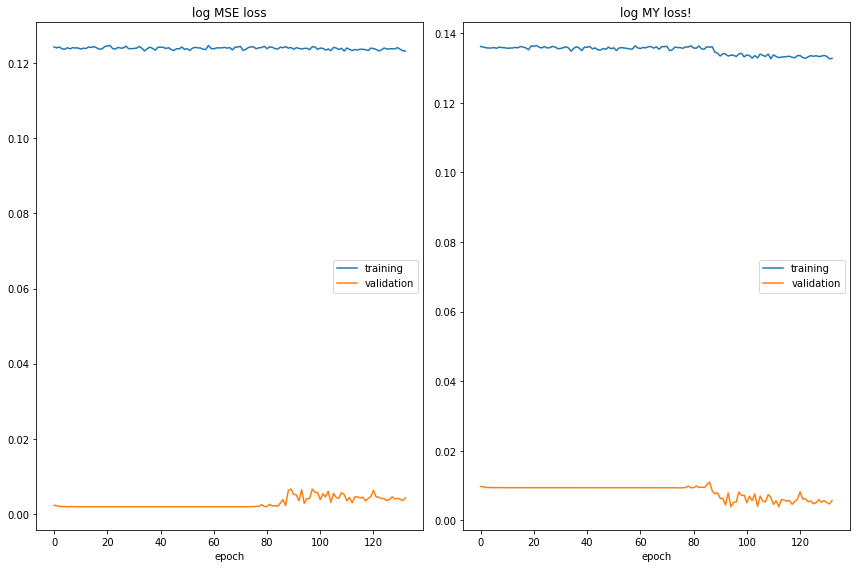

log MSE loss
	training         	 (min:    0.123, max:    0.125, cur:    0.123)
	validation       	 (min:    0.002, max:    0.007, cur:    0.004)
log MY loss!
	training         	 (min:    0.133, max:    0.136, cur:    0.133)
	validation       	 (min:    0.004, max:    0.011, cur:    0.006)


In [ ]:
#device=torch.device("cpu")
# Initialize network
model = CNN_conv2d().to(device)
liveloss = PlotLosses()

# Loss and optimizer
criterion=nn.MSELoss()
#criterion=my_loss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_module=False

ref=1

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_MSE_loss = 0.0
        running_MY_loss = 0.0
        
        running_corrects = 0.0

        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = my_loss(scores, labels)
            #loss = criterion(scores, labels)           
            loss2 = criterion(scores, labels)           
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_MSE_loss += loss2.detach() * inputs.size(0)
            running_MY_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_MSE_loss = running_MSE_loss / len(dataloaders[phase].dataset)            
        epoch_MY_loss = running_MY_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
        
        #if phase == 'validation':
        #    this_loss=(running_loss / len(dataloaders[phase].dataset)).item()
        #    if this_loss<ref:
        #        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        #        # save checkpoint
        #        save_checkpoint(checkpoint)
        #        ref=this_loss
        #        print ("epoch {}:loss{}".format(epoch,ref)) 
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log MSE loss'] = epoch_MSE_loss.item()
        logs[prefix + 'log MY loss!'] = epoch_MY_loss.item()
        #logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



In [112]:
#MAIN
#device = torch.device("cpu")
num_epochs = 26
# Initialize network

model = CNN_conv2d().to(device)

# Loss and optimizer
criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False
print("Current Time =", datetime.now().strftime("%H:%M:%S")) 
# Train Network
for epoch in range(num_epochs):
    now = datetime.now()
    if load_module:
        # load checkpoint
        load_checkpoint(torch.load("my_checkpoint_V3_percent.pth.tar"), model, optimizer)
        load_module=False
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        data=data.float()
        scores = model(data)
        targets=targets.float()
        scores=scores.view(-1)

        #loss = criterion(scores, targets)
        loss = my_loss(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if (epoch % 5==0):
        print(f"Cost at epoch {epoch} is {np.sum(losses)/len(losses)}")
        print("Current Time =", now.strftime("%H:%M:%S")) 
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        # save checkpoint
        save_checkpoint(checkpoint)
        


Current Time = 22:08:30
Cost at epoch 0 is 0.058759485160363986
Current Time = 22:08:30
=> Saving checkpoint
Cost at epoch 5 is 0.05802164931939673
Current Time = 22:12:32
=> Saving checkpoint
Cost at epoch 10 is 0.058482361908709035
Current Time = 22:16:36
=> Saving checkpoint
Cost at epoch 15 is 0.05430829510552613
Current Time = 22:20:37
=> Saving checkpoint
Cost at epoch 20 is 0.05456993818117637
Current Time = 22:24:39
=> Saving checkpoint
Cost at epoch 25 is 0.054282372970923386
Current Time = 22:28:40
=> Saving checkpoint


In [113]:
# Check accuracy on training to see how good our model is

def check_accuracy(loader, model, test_set):
    total_mse=0
    model.eval()
    idx=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x=x.float()
            scores = model(x)
            predictions=scores
            
            MSE=mean_squared_error(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy()))
            total_mse=total_mse+MSE
            idx=idx+1
            if test_set:
                
                np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
                print ("labels:       ",np.ravel(y.cpu().numpy()))
                print ("predictions:  ",np.ravel((predictions.cpu().numpy())))
                print ("mean_squared_error",MSE)
                #print ("r2_score",r2_score(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy())))

    print ("total_mse",total_mse/idx)
        
    model.train()


In [114]:
print("Checking accuracy on Training Set: original images")
check_accuracy(train_loader, model ,test_set=False)

print("Checking accuracy on Test Set: original images")
check_accuracy(test_loader, model, test_set=False)

Checking accuracy on Training Set: original images
total_mse 0.0006053063294393472
Checking accuracy on Test Set: original images
total_mse 0.0007191244939563835


In [115]:
print("Checking accuracy on Test Set")
check_accuracy(test_loader, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.003  0.001  0.007
  0.014  0.014  0.003  0.010  0.004  0.004  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.002  0.001  0.009  0.017  0.015  0.003  0.013
  0.002  0.003  0.000  0.000  0.000  0.001  0.000  0.000  0.001  0.003
  0.001  0.005  0.032  0.018  0.003  0.014  0.001  0.003  0.000  0.000
  0.000  0.001  0.000  0.000  0.001  0.006  0.001  0.008  0.039  0.025
  0.004  0.012  0.001  0.004]
mean_squared_error 8.3989838

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.001  0.002  0.000  0.000  0.003  0.008  0.001  0.002
  0.001  0.005  0.001  0.001  0.001  0.008  0.000  0.000  0.001  0.002
  0.000  0.000  0.003  0.006  0.001  0.002  0.002  0.008  0.001  0.001
  0.001  0.007  0.000  0.000  0.002  0.002  0.000  0.001  0.004  0.004
  0.002  0.003  0.002  0.012  0.002  0.001  0.000  0.010  0.000  0.000
  0.002  0.001  0.000  0.001  0.004  0.003  0.002  0.003  0.002  0.014
  0.002  0.001  0.000  0.012]
mean_squared_error 1.6233650317360704e-05
labels:        [

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.188  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.117  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.001  0.010  0.026  0.010  0.010  0.106  0.031  0.028  0.036
  0.040  0.035  0.001  0.005  0.011  0.010  0.000  0.001  0.007  0.019
  0.011  0.008  0.083  0.018  0.029  0.031  0.038  0.037  0.003  0.005
  0.014  0.009  0.000  0.001  0.007  0.012  0.008  0.006  0.084  0.012
  0.029  0.037  0.032  0.032  0.005  0.003  0.013  0.008  0.000  0.001
  0.004  0.009  0.005  0.008  0.043  0.008  0.026  0.034  0.025  0.018
  0.007  0.002  0.009  0.008]
mean_squared_error 0.0005905443162289999
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.001  0.004  0.002  0.000  0.002  0.022  0.005  0.003  0.002
  0.004  0.011  0.002  0.008  0.003  0.034  0.000  0.001  0.008  0.002
  0.001  0.003  0.024  0.006  0.004  0.002  0.004  0.011  0.002  0.010
  0.003  0.057  0.000  0.001  0.011  0.002  0.001  0.005  0.029  0.008
  0.004  0.002  0.006  0.012  0.002  0.009  0.004  0.076  0.000  0.001
  0.012  0.002  0.001  0.008  0.030  0.007  0.005  0.002  0.008  0.016
  0.002  0.007  0.005  0.079]
mean_squared_error 0.000329637403613593
labels:        [ 0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.002  0.002  0.000  0.003  0.007  0.003  0.006  0.012  0.042
  0.032  0.001  0.002  0.002  0.006  0.040  0.000  0.001  0.003  0.001
  0.001  0.003  0.002  0.005  0.013  0.031  0.024  0.001  0.003  0.002
  0.009  0.044  0.000  0.000  0.002  0.001  0.001  0.002  0.001  0.005
  0.013  0.029  0.026  0.001  0.004  0.003  0.007  0.064  0.000  0.000
  0.001  0.002  0.001  0.002  0.002  0.005  0.012  0.030  0.029  0.002
  0.005  0.003  0.006  0.024]
mean_squared_error 0.0002658955368498902
labels:        [ 

predictions:   [ 0.001  0.000  0.025  0.019  0.012  0.019  0.053  0.017  0.011  0.006
  0.008  0.019  0.005  0.002  0.004  0.016  0.001  0.001  0.037  0.030
  0.014  0.019  0.062  0.022  0.013  0.005  0.009  0.022  0.005  0.003
  0.004  0.013  0.002  0.001  0.044  0.047  0.016  0.022  0.073  0.029
  0.017  0.004  0.009  0.026  0.004  0.003  0.004  0.010  0.002  0.001
  0.060  0.093  0.021  0.024  0.072  0.036  0.017  0.004  0.011  0.029
  0.005  0.003  0.004  0.007]
mean_squared_error 0.000735620477281643
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.000  0.003
  0.022  0.002  0.001  0.000  0.001  0.003  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.001  0.000  0.001  0.009  0.002  0.001  0.000
  0.001  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001
  0.000  0.001  0.004  0.004  0.001  0.000  0.001  0.002  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.002  0.005
  0.001  0.000  0.001  0.002]
mean_squared_error 1.087960678879992e-05
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.082  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.160  0.000  0.000  0.000  0.020  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.005  0.059  0.012  0.006  0.054  0.033  0.016  0.076  0.020
  0.009  0.008  0.002  0.002  0.003  0.008  0.000  0.006  0.070  0.015
  0.006  0.073  0.031  0.014  0.085  0.019  0.010  0.010  0.003  0.002
  0.003  0.012  0.000  0.007  0.085  0.015  0.007  0.082  0.031  0.014
  0.090  0.029  0.010  0.012  0.004  0.003  0.003  0.017  0.000  0.008
  0.079  0.015  0.009  0.101  0.034  0.012  0.080  0.035  0.008  0.013
  0.006  0.003  0.002  0.020]
mean_squared_error 0.0011088173623155357
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002  0.000  0.000
  0.001  0.010  0.001  0.000  0.000  0.001  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.003  0.000  0.000  0.001  0.008  0.001  0.000
  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.004
  0.000  0.000  0.002  0.006  0.001  0.000  0.001  0.002  0.000  0.000
  0.000  0.000  0.000  0.000  0.001  0.005  0.000  0.000  0.003  0.006
  0.001  0.000  0.001  0.003]
mean_squared_error 4.790419452167157e-06
labels:        [ 

predictions:   [ 0.000  0.002  0.031  0.013  0.012  0.096  0.104  0.033  0.045  0.027
  0.014  0.028  0.010  0.002  0.004  0.007  0.000  0.003  0.038  0.023
  0.009  0.068  0.089  0.026  0.050  0.023  0.014  0.024  0.012  0.002
  0.004  0.005  0.000  0.002  0.048  0.034  0.007  0.035  0.065  0.023
  0.048  0.020  0.011  0.020  0.012  0.003  0.004  0.005  0.000  0.002
  0.055  0.038  0.006  0.021  0.044  0.023  0.036  0.019  0.007  0.018
  0.011  0.004  0.003  0.005]
mean_squared_error 0.000683637751407835
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.001  0.000  0.000  0.001  0.001  0.000  0.001
  0.014  0.003  0.002  0.005  0.002  0.019  0.000  0.000  0.000  0.001
  0.000  0.000  0.001  0.001  0.000  0.001  0.022  0.004  0.002  0.007
  0.002  0.026  0.000  0.000  0.000  0.001  0.000  0.000  0.001  0.001
  0.000  0.001  0.025  0.005  0.003  0.008  0.003  0.020  0.000  0.000
  0.000  0.002  0.000  0.000  0.002  0.001  0.000  0.002  0.026  0.008
  0.004  0.009  0.005  0.021]
mean_squared_error 6.713043736496311e-05
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.007  0.005  0.002  0.001  0.020  0.014  0.002  0.002
  0.004  0.013  0.002  0.002  0.003  0.005  0.000  0.000  0.006  0.003
  0.001  0.001  0.016  0.011  0.001  0.001  0.005  0.010  0.002  0.002
  0.003  0.008  0.000  0.000  0.005  0.003  0.001  0.001  0.010  0.007
  0.001  0.001  0.005  0.011  0.002  0.002  0.002  0.008  0.000  0.000
  0.003  0.003  0.001  0.001  0.009  0.004  0.002  0.001  0.005  0.010
  0.002  0.002  0.002  0.008]
mean_squared_error 3.585546505704595e-05
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.003  0.001  0.019  0.037  0.009  0.041  0.020
  0.036  0.013  0.001  0.000  0.005  0.008  0.000  0.000  0.000  0.003
  0.002  0.019  0.047  0.009  0.043  0.032  0.037  0.019  0.002  0.000
  0.006  0.007  0.000  0.000  0.000  0.002  0.002  0.018  0.042  0.009
  0.043  0.032  0.037  0.024  0.001  0.000  0.005  0.006  0.000  0.000
  0.001  0.002  0.002  0.022  0.035  0.010  0.041  0.029  0.034  0.027
  0.001  0.001  0.003  0.005]
mean_squared_error 0.0004068538675580157
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.001  0.001  0.001  0.004  0.008  0.003  0.018  0.007  0.007  0.003
  0.002  0.017  0.004  0.002  0.000  0.001  0.001  0.002  0.001  0.002
  0.007  0.003  0.012  0.008  0.007  0.003  0.003  0.013  0.005  0.002
  0.001  0.000  0.001  0.001  0.001  0.001  0.006  0.003  0.008  0.017
  0.006  0.003  0.003  0.012  0.006  0.002  0.001  0.000  0.000  0.001
  0.001  0.000  0.005  0.005  0.006  0.027  0.005  0.004  0.004  0.008
  0.006  0.002  0.001  0.001]
mean_squared_error 4.660917339482026e-05
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.402  0.148  0.000  0.000  0.242
  0.129  0.000  0.000  0.000  0.000  0.000  0.000  0.004  0.000  0.000
  0.000  0.340  0.113  0.000  0.000  0.195  0.023  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.250  0.039  0.000
  0.000  0.137  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.090  0.008  0.000  0.000  0.020  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.027  0.002  0.007  0.003  0.200  0.049  0.030  0.024  0.161
  0.016  0.025  0.004  0.002  0.002  0.037  0.000  0.029  0.003  0.009
  0.004  0.118  0.057  0.037  0.016  0.152  0.009  0.023  0.005  0.002
  0.002  0.044  0.000  0.032  0.003  0.010  0.006  0.067  0.050  0.036
  0.013  0.118  0.006  0.022  0.005  0.002  0.002  0.048  0.000  0.029
  0.004  0.009  0.008  0.037  0.038  0.026  0.009  0.042  0.004  0.021
  0.005  0.002  0.001  0.049]
mean_squared_error 0.002838761895810847
labels:        [ 0

predictions:   [ 0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.001  0.002  0.001
  0.000  0.001  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.001  0.000  0.000  0.001  0.002  0.001  0.001  0.001  0.001  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.001
  0.002  0.000  0.001  0.001  0.002  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.001  0.000  0.000  0.002  0.001  0.000  0.002  0.002
  0.002  0.001  0.000  0.001]
mean_squared_error 7.623439003099904e-07
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.004  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.004  0.016  0.004  0.007  0.011  0.017  0.008  0.041  0.022
  0.044  0.038  0.010  0.002  0.001  0.006  0.000  0.004  0.019  0.003
  0.004  0.013  0.018  0.008  0.034  0.027  0.051  0.044  0.006  0.002
  0.001  0.005  0.000  0.003  0.020  0.002  0.003  0.014  0.019  0.008
  0.023  0.033  0.055  0.044  0.004  0.002  0.001  0.005  0.000  0.002
  0.017  0.002  0.002  0.013  0.019  0.008  0.017  0.033  0.052  0.036
  0.003  0.002  0.001  0.004]
mean_squared_error 0.00043667973927906005
labels:        [

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.001  0.000  0.000  0.005  0.003  0.001  0.003
  0.005  0.014  0.004  0.002  0.002  0.003  0.000  0.000  0.001  0.000
  0.000  0.001  0.003  0.003  0.001  0.003  0.008  0.013  0.006  0.003
  0.001  0.004  0.000  0.000  0.001  0.000  0.000  0.001  0.002  0.004
  0.001  0.004  0.009  0.009  0.005  0.002  0.001  0.004  0.000  0.000
  0.001  0.000  0.000  0.002  0.002  0.004  0.001  0.005  0.011  0.005
  0.005  0.002  0.001  0.004]
mean_squared_error 1.7467797259338857e-05
labels:        [

predictions:   [ 0.000  0.002  0.031  0.013  0.004  0.021  0.139  0.021  0.006  0.004
  0.006  0.016  0.003  0.004  0.001  0.003  0.000  0.002  0.019  0.018
  0.002  0.025  0.113  0.017  0.009  0.006  0.008  0.012  0.003  0.003
  0.002  0.002  0.000  0.001  0.010  0.027  0.001  0.021  0.045  0.011
  0.012  0.010  0.009  0.009  0.002  0.003  0.003  0.001  0.000  0.001
  0.005  0.023  0.001  0.009  0.025  0.007  0.009  0.011  0.009  0.007
  0.002  0.002  0.003  0.001]
mean_squared_error 0.0014602089390351922
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.002  0.003  0.000  0.004  0.008  0.025  0.001  0.009
  0.011  0.031  0.003  0.003  0.003  0.013  0.000  0.000  0.002  0.002
  0.000  0.003  0.005  0.022  0.002  0.007  0.009  0.045  0.003  0.003
  0.004  0.022  0.000  0.000  0.001  0.001  0.000  0.002  0.003  0.020
  0.004  0.006  0.009  0.043  0.004  0.002  0.006  0.024  0.000  0.001
  0.000  0.001  0.000  0.003  0.002  0.018  0.009  0.010  0.011  0.043
  0.005  0.002  0.006  0.025]
mean_squared_error 0.00018070695427006088
labels:        [

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.316  0.238  0.000  0.039  0.332
  0.105  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.301  0.258  0.000  0.047  0.344  0.105  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.285  0.266  0.000
  0.059  0.336  0.094  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.262  0.219  0.000  0.031  0.293  0.082  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.010  0.012  0.037  0.004  0.420  0.099  0.040  0.045  0.296
  0.042  0.059  0.001  0.003  0.003  0.004  0.000  0.009  0.018  0.021
  0.003  0.409  0.112  0.045  0.056  0.295  0.036  0.046  0.001  0.003
  0.002  0.004  0.000  0.006  0.023  0.012  0.003  0.323  0.124  0.038
  0.055  0.281  0.030  0.038  0.003  0.004  0.002  0.004  0.000  0.004
  0.020  0.008  0.002  0.245  0.111  0.030  0.048  0.254  0.032  0.034
  0.004  0.003  0.002  0.004]
mean_squared_error 0.0021639398416706014
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.001  0.003  0.007  0.006  0.005  0.060  0.027  0.007  0.018  0.146
  0.068  0.024  0.022  0.003  0.003  0.027  0.001  0.002  0.003  0.007
  0.004  0.049  0.031  0.006  0.018  0.216  0.065  0.025  0.019  0.002
  0.003  0.033  0.000  0.001  0.001  0.008  0.003  0.037  0.032  0.009
  0.019  0.236  0.058  0.027  0.012  0.002  0.003  0.026  0.000  0.001
  0.001  0.007  0.003  0.025  0.033  0.014  0.017  0.245  0.048  0.022
  0.007  0.003  0.003  0.019]
mean_squared_error 0.0034114273390340698
labels:        [ 

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.003  0.001  0.000  0.002  0.004  0.012  0.003  0.028
  0.014  0.021  0.003  0.003  0.006  0.031  0.000  0.000  0.001  0.002
  0.000  0.004  0.005  0.011  0.005  0.031  0.012  0.028  0.004  0.003
  0.005  0.018  0.000  0.001  0.001  0.002  0.000  0.008  0.010  0.007
  0.005  0.023  0.012  0.037  0.004  0.004  0.004  0.015  0.000  0.001
  0.000  0.002  0.000  0.014  0.017  0.004  0.005  0.020  0.019  0.044
  0.004  0.005  0.003  0.015]
mean_squared_error 0.00017417466012782003
labels:        [

In [87]:
#method to add poisson noise to images

def make_noisy_image(image, PEAK=1):
    img=np.zeros(image.shape)
    for idx, _2d_img in enumerate(image):  
        
        theta = np.linspace(0., 180., max(_2d_img.shape), endpoint=False)
        sinogram = radon(_2d_img, theta=theta, circle=False)
        sinogram=np.clip(sinogram, 0,None)
        noisy = np.random.poisson(sinogram * PEAK)/PEAK  
        img[idx] = iradon(noisy, theta=theta, circle=False)
    return img

In [129]:
#again load all images, add pading if needed, then add poisson noise for 4 different levels

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'
#_ct_gtvt.nii.gz
#_pt.nii.gz
files = [f for f in glob.glob(path + "**/*_pt.nii.gz", recursive=True)]
noisy_image_list1=list()
noisy_image_list2=list()
noisy_image_list3=list()

for idx,f in enumerate(files):
    
    im=nib.load(f)
    PET_data=im.get_fdata()   
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    PET_data1=make_noisy_image(PET_data , 0.5)   
    noisy_image_list1.append(PET_data1)
    PET_data2=make_noisy_image(PET_data , 1)   
    noisy_image_list2.append(PET_data2)
    PET_data3=make_noisy_image(PET_data , 5)   
    noisy_image_list3.append(PET_data3)
    


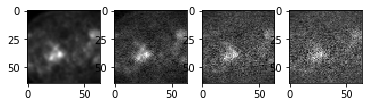

In [130]:
fig = plt.figure()
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(image_list[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(noisy_image_list3[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(noisy_image_list2[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(noisy_image_list1[0][:,:,50],cmap='gray')



In [120]:
#make image patches of size 16*16*16
size=16
stride=16

all_noisy_PET_patches1=list()
all_noisy_PET_patches2=list()
all_noisy_PET_patches3=list()

for PET_img in noisy_image_list1:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_noisy_PET_patches1.append(reshaped_patches)
all_noisy_PET_patches1=np.asarray(all_noisy_PET_patches1).reshape(-1,size,size)

for PET_img in noisy_image_list2:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_noisy_PET_patches2.append(reshaped_patches)
all_noisy_PET_patches2=np.asarray(all_noisy_PET_patches2).reshape(-1,size,size)

for PET_img in noisy_image_list3:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_noisy_PET_patches3.append(reshaped_patches)
all_noisy_PET_patches3=np.asarray(all_noisy_PET_patches3).reshape(-1,size,size)


In [121]:
#class dataset of noisy images
class noisy_HN_Dataset(Dataset):
    def __init__(self,images, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=images
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))        
        if self.transform is not None:
            PET_data = self.transform(self.images[idx])
        return (PET_data, label)

In [122]:
#making train and test set for noisy image

split_threshold=170000
idx = list(range(len(all_labels)))

noisy_dataset1 = noisy_HN_Dataset(all_noisy_PET_patches1, transform=tv.transforms.ToTensor())
noisy_dataset2 = noisy_HN_Dataset(all_noisy_PET_patches2, transform=tv.transforms.ToTensor())
noisy_dataset3 = noisy_HN_Dataset(all_noisy_PET_patches3, transform=tv.transforms.ToTensor())
noisy_dataset4 = noisy_HN_Dataset(all_noisy_PET_patches4, transform=tv.transforms.ToTensor())

################################ IMPOSTANT ############################################
#As I don't use "randome split" for splitting test and train set, we can easily compare results of this test set with previous one(no noise test set)
noisy_train_set1 = DT.Subset(noisy_dataset1, idx[:split_threshold])
noisy_test_set1 = DT.Subset(noisy_dataset1, idx[split_threshold:])

noisy_train_set2 = DT.Subset(noisy_dataset2, idx[:split_threshold])
noisy_test_set2 = DT.Subset(noisy_dataset2, idx[split_threshold:])

noisy_train_set3 = DT.Subset(noisy_dataset3, idx[:split_threshold])
noisy_test_set3 = DT.Subset(noisy_dataset3, idx[split_threshold:])

noisy_train_set4 = DT.Subset(noisy_dataset4, idx[:split_threshold])
noisy_test_set4 = DT.Subset(noisy_dataset4, idx[split_threshold:])
######################################################################################

PET_patch_mean_noisy1=np.mean(all_noisy_PET_patches1[:split_threshold] , axis=(0,1,2))
PET_patch_std_noisy1=np.std(all_noisy_PET_patches1[:split_threshold] , axis=(0,1,2))

PET_patch_mean_noisy2=np.mean(all_noisy_PET_patches2[:split_threshold] , axis=(0,1,2))
PET_patch_std_noisy2=np.std(all_noisy_PET_patches2[:split_threshold] , axis=(0,1,2))

PET_patch_mean_noisy3=np.mean(all_noisy_PET_patches3[:split_threshold] , axis=(0,1,2))
PET_patch_std_noisy3=np.std(all_noisy_PET_patches3[:split_threshold] , axis=(0,1,2))

#############################################################################################
"""
noisy_test_set1.transform= tv.transforms.Compose([tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                                   ])

noisy_test_set2.transform= tv.transforms.Compose([tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                                   ])

noisy_test_set3.transform= tv.transforms.Compose([tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                                   ])
"""
############################################################################################
#noisy_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
noisy_test_loader1 = DataLoader(noisy_test_set1, batch_size=batch_size, shuffle=False)
noisy_test_loader2 = DataLoader(noisy_test_set2, batch_size=batch_size, shuffle=False)
noisy_test_loader3 = DataLoader(noisy_test_set3, batch_size=batch_size, shuffle=False)
#noisy_test_loader4 = DataLoader(noisy_test_set4, batch_size=batch_size, shuffle=False)

In [123]:
print("**********Checking accuracy on Test Set3: low noise**********")
check_accuracy(noisy_test_loader3, model, test_set=False)
#print("**********Checking accuracy on Test Set4**********")
#check_accuracy(noisy_test_loader4, model, test_set=False)
print("**********Checking accuracy on Test Set2: mid noise**********")
check_accuracy(noisy_test_loader2, model, test_set=False)

print("**********Checking accuracy on Test Set1: high noise**********")
check_accuracy(noisy_test_loader1, model, test_set=False)

**********Checking accuracy on Test Set3: low noise**********
total_mse 0.0006654935638661391
**********Checking accuracy on Test Set2: mid noise**********
total_mse 0.001200162116925948
**********Checking accuracy on Test Set1: high noise**********
total_mse 0.0018472178488449223


In [124]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader3, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.277  0.773  0.000  0.000  0.043
  0.105  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.285  0.754  0.000  0.000  0.035  0.094  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.266  0.742  0.000
  0.000  0.035  0.098  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.262  0.727  0.000  0.000  0.031  0.094  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.223
  0.723  0.000  0.000  0.012  0.074  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.188  0.621  0.000  0.000  0.008
  0.051  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.141  0.559  0.000  0.000  0.000  0.031  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.031  0.418  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.001  0.000  0.000  0.005  0.030  0.725  0.005  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.001  0.000  0.000  0.001  0.001  0.002  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.002  0.001  0.001
  0.000  0.001  0.002  0.001  0.001  0.004  0.000  0.000  0.000  0.000
  0.001  0.002  0.001  0.004  0.001  0.001  0.002  0.001  0.002  0.001
  0.003  0.004  0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.004
  0.001  0.001  0.001  0.002  0.002  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.001  0.002  0.012  0.001  0.000  0.001  0.002
  0.003  0.000  0.000  0.001  0.000  0.000  0.000  0.001  0.000  0.001
  0.001  0.007  0.001  0.001  0.000  0.002  0.002  0.001  0.000  0.001
  0.000  0.000  0.000  0.001  0.000  0.000  0.001  0.003  0.001  0.001
  0.000  0.007  0.001  0.001  0.000  0.001  0.000  0.000  0.000  0.002
  0.000  0.001  0.001  0.004  0.001  0.001  0.001  0.007  0.001  0.001
  0.000  0.002  0.000  0.000  0.001  0.003  0.000  0.000  0.002  0.003
  0.001  0.002  0.000  0.002  0.001  0.001  0.000  0.006]
mean_squared_error 4.268946210857834e-06
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.011  0.027  0.000  0.

predictions:   [ 0.000  0.007  0.035  0.004  0.003  0.113  0.036  0.012  0.023  0.011
  0.001  0.003  0.001  0.000  0.001  0.009  0.000  0.001  0.028  0.001
  0.005  0.155  0.024  0.011  0.013  0.020  0.002  0.005  0.004  0.000
  0.000  0.011  0.000  0.001  0.030  0.002  0.003  0.156  0.021  0.037
  0.007  0.014  0.005  0.004  0.004  0.000  0.000  0.003  0.000  0.001
  0.065  0.001  0.003  0.186  0.030  0.036  0.020  0.014  0.002  0.005
  0.005  0.000  0.000  0.006  0.000  0.001  0.049  0.006  0.005  0.167
  0.052  0.033  0.010  0.010  0.001  0.003  0.002  0.001  0.000  0.007
  0.000  0.001  0.038  0.002  0.001  0.184  0.040  0.064  0.031  0.011
  0.003  0.005  0.004  0.000  0.000  0.008  0.000  0.003  0.032  0.008
  0.002  0.185  0.043  0.019  0.008  0.021  0.004  0.006  0.002  0.000
  0.001  0.004  0.000  0.000  0.026  0.000  0.001  0.144  0.054  0.031
  0.049  0.008  0.001  0.003  0.003  0.000  0.000  0.015]
mean_squared_error 0.001974909585270018
labels:        [ 0.000  0.000  0.00

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.001  0.005  0.000  0.037  0.002  0.001  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001
  0.000  0.000  0.000  0.002  0.001  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.003
  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.001  0.000  0.000  0.000  0.006  0.000  0.000  0.000  0.001
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.005  0.001  0.000  0.000  0.001  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.007  0.001  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.001
  0.000  0.000  0.000  0.005  0.001  0.000  0.000  0.001]
mean_squared_error 1.4173238896901643e-06
labels:        [ 0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.001  0.002  0.001  0.003  0.009
  0.005  0.012  0.001  0.002  0.001  0.076  0.000  0.000  0.000  0.000
  0.000  0.002  0.009  0.004  0.002  0.017  0.005  0.001  0.002  0.001
  0.002  0.114  0.000  0.000  0.000  0.000  0.000  0.003  0.005  0.003
  0.003  0.013  0.002  0.002  0.004  0.002  0.004  0.081  0.000  0.000
  0.000  0.000  0.000  0.003  0.015  0.002  0.002  0.016  0.001  0.008
  0.002  0.001  0.004  0.055  0.000  0.000  0.001  0.000  0.000  0.007
  0.009  0.002  0.003  0.019  0.004  0.009  0.003  0.001  0.008  0.042
  0.000  0.000  0.001  0.000  0.000  0.009  0.012  0.001  0.002  0.005
  0.011  0.009  0.006  0.001  0.002  0.029  0.000  0.000  0.001  0.000
  0.000  0.012  0.016  0.001  0.004  0.009  0.003  0.008  0.001  0.006
  0.001  0.017  0.000  0.000  0.001  0.000  0.000  0.012  0.007  0.004
  0.001  0.003  0.013  0.005  0.002  0.002  0.002  0.015]
mean_squared_error 0.00027544822434372943
labels:        [ 0.000  0.000  0.

predictions:   [ 0.000  0.000  0.005  0.009  0.002  0.000  0.013  0.241  0.012  0.007
  0.002  0.009  0.003  0.000  0.001  0.012  0.000  0.000  0.009  0.004
  0.002  0.000  0.018  0.203  0.004  0.006  0.002  0.022  0.002  0.002
  0.001  0.013  0.000  0.001  0.014  0.005  0.005  0.001  0.007  0.124
  0.016  0.008  0.010  0.010  0.001  0.001  0.000  0.010  0.000  0.000
  0.011  0.005  0.002  0.000  0.002  0.056  0.004  0.003  0.008  0.022
  0.003  0.002  0.001  0.006  0.000  0.001  0.010  0.002  0.008  0.000
  0.005  0.041  0.003  0.010  0.005  0.011  0.001  0.001  0.000  0.010
  0.000  0.001  0.027  0.001  0.007  0.004  0.003  0.033  0.021  0.004
  0.001  0.020  0.002  0.001  0.000  0.003  0.000  0.002  0.012  0.010
  0.005  0.004  0.012  0.010  0.010  0.004  0.002  0.017  0.003  0.000
  0.000  0.007  0.000  0.001  0.019  0.003  0.006  0.007  0.038  0.007
  0.005  0.001  0.001  0.050  0.002  0.001  0.000  0.004]
mean_squared_error 0.0016035234963697306
labels:        [ 0.000  0.000  0.0

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.005  0.001  0.001  0.002  0.001
  0.000  0.002  0.001  0.001  0.007  0.024  0.000  0.000  0.000  0.000
  0.001  0.004  0.002  0.000  0.001  0.001  0.002  0.002  0.001  0.002
  0.001  0.047  0.000  0.000  0.000  0.000  0.001  0.002  0.001  0.000
  0.001  0.000  0.001  0.000  0.001  0.000  0.001  0.021  0.000  0.000
  0.000  0.000  0.000  0.002  0.001  0.000  0.001  0.001  0.002  0.002
  0.001  0.000  0.000  0.020  0.000  0.000  0.000  0.000  0.000  0.003
  0.001  0.001  0.001  0.000  0.003  0.000  0.001  0.002  0.000  0.015
  0.000  0.000  0.000  0.000  0.000  0.003  0.001  0.001  0.001  0.001
  0.001  0.001  0.001  0.001  0.001  0.020  0.000  0.000  0.000  0.000
  0.000  0.001  0.001  0.000  0.002  0.001  0.000  0.000  0.001  0.000
  0.002  0.010  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.001  0.003  0.000  0.001  0.001  0.001  0.001  0.012]
mean_squared_error 3.690730460083921e-05
labels:        [ 0.000  0.000  0.0

  0.000  0.002  0.001  0.000  0.000  0.000  0.000  0.012]
mean_squared_error 2.4282376717756262e-06
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.0

predictions:   [ 0.000  0.002  0.000  0.001  0.000  0.005  0.026  0.003  0.008  0.002
  0.009  0.005  0.003  0.000  0.001  0.032  0.000  0.001  0.000  0.003
  0.000  0.002  0.021  0.005  0.002  0.008  0.011  0.002  0.001  0.001
  0.000  0.009  0.000  0.005  0.001  0.010  0.001  0.002  0.039  0.002
  0.008  0.006  0.010  0.013  0.001  0.000  0.000  0.012  0.000  0.003
  0.001  0.019  0.001  0.024  0.052  0.007  0.008  0.010  0.004  0.003
  0.002  0.000  0.001  0.005  0.000  0.003  0.001  0.006  0.002  0.005
  0.041  0.005  0.008  0.001  0.002  0.001  0.006  0.000  0.000  0.009
  0.000  0.002  0.001  0.014  0.002  0.014  0.031  0.008  0.002  0.004
  0.004  0.006  0.002  0.001  0.001  0.010  0.000  0.002  0.000  0.002
  0.002  0.008  0.018  0.015  0.004  0.007  0.003  0.011  0.002  0.001
  0.000  0.011  0.000  0.004  0.000  0.014  0.002  0.005  0.010  0.022
  0.016  0.013  0.003  0.001  0.000  0.002  0.001  0.015]
mean_squared_error 0.00011613002958967213
labels:        [ 0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.007  0.000  0.002  0.001  0.006  0.006  0.012  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.001  0.

In [125]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader2, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.010
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.006  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 1.0879201949753627e-06
labels:        [ 0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.001  0.000  0.000  0.000  0.001  0.006  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.504  0.027  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.523  0.027  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.539  0.031
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.582  0.043  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.605  0.059  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.004  0.000  0.000  0.000  0.578  0.145  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.020  0.027
  0.000  0.000  0.559  0.281  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.023  0.055  0.000  0.000  0.562  0.305
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.100  0.007  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.293  0.066  0.000  0.000  0.035
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.250  0.059  0.000  0.000  0.008  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.121  0.047  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.043  0.027  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.003  0.053  0.000  0.

  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.012  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.007  0.000  0.000
  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.022  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.002
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.008  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_erro

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.055  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.009  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.003
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 6.429651690236638e-07
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.012
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.121  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.207  0.000  0.000  0.000  0.016  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.238  0.000  0.000
  0.000  0.027  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.005  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001]
mean_squared_error 3.320289982141425e-07
labels:        [ 0.000  0.000  0.0

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.005
  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000  0.000  0.000
  0.000  0.001  0.014  0.000  0.000  0.000  0.001  0.000  0.000  0.000
  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.002  0.015  0.000
  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.001]
mean_squared_error 0.006193071964818868
labels:        [ 0.000  0.000  0.00

  0.000  0.039  0.129  0.012  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.020  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.016  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.007  0.129  0.005
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000
  0.000  0.000  0.000  0.005  0.289  0.123  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.045
  0.454  0.135  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.002  0.639  0.140  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.035  0.496  0.207  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.001  0.585  0.129
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_erro

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.003
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.002  0.000  0.000  0.000  0.000  0.001
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.004  0.000  0.000  0.001  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.005  0.000  0.000
  0.000  0.005  0.000  0.000  0.000  0.000  0.000  0.000  0.006  0.000
  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.004]
mean_squared_error 0.0003034558247139523
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.070  0.008  0.000  0.000
  0.129  0.008  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.082  0.000  0.000  0.000  0.109  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.102  0.000
  0.000  0.000  0.094  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.117  0.000  0.000  0.000  0.055  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.113  0.000  0.000  0.000  0.027  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.062  0.000  0.000  0.000
  0.004  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.031
  0.001  0.000  0.000  0.000  0.000  0.025  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.003  0.000  0.000  0.000
  0.000  0.002  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.005  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.004  0.022  0.000
  0.000  0.000  0.000  0.006  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.011  0.000  0.000  0.000  0.000  0.000  0.005
  0.000  0.000  0.000  0.000  0.000  0.000  0.004  0.000  0.000  0.006
  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000  0.000  0.000
  0.000  0.000  0.003  0.000  0.001  0.000  0.000  0.000  0.000  0.000
  0.000  0.003  0.000  0.000  0.000  0.000  0.000  0.001  0.043  0.000
  0.001  0.000  0.000  0.000  0.000  0.000  0.000  0.001]
mean_squared_error 0.0009085602051597191
labels:        [ 0.000  0.000  0.0

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.413  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.334  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.391  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.000  0.000
  0.000  0.000  0.000  0.000  0.433  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.001
  0.186  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.002  0.022  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.001  0.000  0.000  0.000  0.000
  0.000  0.002  0.044  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.005  0.000  0.000  0.000  0.000  0.000  0.002  0.001  0.000
  0.000  0.001  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 0.006222567621657477
labels:        [ 0.000  0.000  0.00

In [126]:
print("Checking accuracy on Test Set")
check_accuracy(noisy_test_loader1, model, test_set=True)

Checking accuracy on Test Set
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.109  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.012  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.078  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.152  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.203  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.195  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 6.323731102664356e-15
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.316  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.133  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.016  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.004]
mean_squared_error 1.500282604396113e-07
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 1.819737782303576e-13
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.082  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.160  0.000  0.000
  0.000  0.020  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.008  0.000  0.000  0.000
  0.031  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.066  0.000  0.000  0.000  0.098  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.082  0.000
  0.000  0.000  0.137  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.020  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.047  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.066  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.098
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.117  0.000  0.000  0.000  0.008
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.117  0.000  0.000  0.000  0.008  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.098  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.023
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.074  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.082  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.113  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 3.533367664152135e-11
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.008  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.008  0.062  0.000  0.000  0.004  0.035  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.023  0.086  0.000
  0.000  0.012  0.066  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.023  0.098  0.000  0.000  0.020  0.102  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.027
  0.172  0.000  0.000  0.031  0.148  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.027  0.203  0.000  0.000  0.039
  0.180  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.027  0.238  0.000  0.000  0.051  0.184  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.027  0.262  0.000
  0.000  0.062  0.191  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 4.999447222750051e-12
labels:        [ 0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.340  0.348  0.000  0.000  0.266
  0.215  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.379  0.328  0.000  0.000  0.277  0.215  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.395  0.281  0.000
  0.000  0.277  0.188  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.410  0.188  0.000  0.000  0.254  0.145  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.402
  0.148  0.000  0.000  0.242  0.129  0.000  0.000  0.000  0.000  0.000
  0.000  0.004  0.000  0.000  0.000  0.340  0.113  0.000  0.000  0.195
  0.023  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.250  0.039  0.000  0.000  0.137  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.090  0.008  0.000
  0.000  0.020  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.172  0.055  0.000  0.000
  0.094  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.195  0.086  0.000  0.000  0.098  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.199  0.094
  0.000  0.000  0.090  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.195  0.078  0.000  0.000  0.066  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.180  0.066  0.000  0.000  0.023  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.141  0.043  0.000  0.000
  0.004  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.059  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.004  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.031
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.074  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.098  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.090  0.012  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.250  0.000  0.000  0.000
  0.043  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.281  0.000  0.000  0.000  0.051  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.305  0.000
  0.000  0.000  0.051  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.293  0.000  0.000  0.000  0.039  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.254  0.000  0.000  0.000  0.031  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.203  0.000  0.000  0.000
  0.016  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.086  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 1.0328938176798506e-13
labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.0

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

labels:        [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.016  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.141  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.043  0.348  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

predictions:   [ 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000]
mean_squared_error 4.790923201246499e-13
labels:        [ 0.000  0.000  0.0

In [141]:
#print("Checking accuracy on Test Set")
#check_accuracy(noisy_test_loader4, model, test_set=True)

In [152]:
print ("PET_patch_mean_noisy1",PET_patch_mean_noisy1)
print ("PET_patch_mean_noisy2",PET_patch_mean_noisy2)
print ("PET_patch_mean_noisy3",PET_patch_mean_noisy3)
print ("PET_patch_mean",PET_patch_mean)

PET_patch_mean_noisy1 1.084530477380603
PET_patch_mean_noisy2 1.0845625353550765
PET_patch_mean_noisy3 1.0845660893006457
PET_patch_mean 1.0854959444340517
